In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, SGDRegressor
import xgboost as xgb
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor, SVR

## 1. Defining Functions:

### 1.1 Preprocessing Functions:

In [2]:
def calc_change_sentiment(data):
    change_in_sent = []
    change_in_sent.append(data['compound'][0])
    for i in range(1,len(data['compound'])):
        if data['compound'][i] == 0:
            change_in_sent.append(0)
        elif data['compound'][i] < 0 or data['compound'][i] > 0:
            dif = data['compound'][i] - data['compound'][(i-1)]
            change_in_sent.append(dif)
    return change_in_sent

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)       
    return input_txt
    
def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")  
    return tweets

In [3]:
def classify_news(dataframe):
    day23, day24, day25, day26, day27, day28, day29, day30, day31, day32, day33, day34, day35, day36, day37, day38 = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]

    for i in range(len(dataframe['timestamp'])):
        if dataframe['timestamp'][i].day == 23 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day23.append(i)
        elif dataframe['timestamp'][i].day == 24 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day24.append(i)       
        elif dataframe['timestamp'][i].day == 25 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day25.append(i)
        elif dataframe['timestamp'][i].day == 26 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day26.append(i)
        elif dataframe['timestamp'][i].day == 27 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day27.append(i)
        elif dataframe['timestamp'][i].day == 28 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day28.append(i)
        elif dataframe['timestamp'][i].day == 29 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day29.append(i)
        elif dataframe['timestamp'][i].day == 30 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day30.append(i)
        elif dataframe['timestamp'][i].day == 1 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day31.append(i)
        elif dataframe['timestamp'][i].day == 2 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day32.append(i)
        elif dataframe['timestamp'][i].day == 3 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day33.append(i)
        elif dataframe['timestamp'][i].day == 4 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day34.append(i)
        elif dataframe['timestamp'][i].day == 5 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day35.append(i)
        elif dataframe['timestamp'][i].day == 6 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day36.append(i)
        elif dataframe['timestamp'][i].day == 7 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day37.append(i)
        elif dataframe['timestamp'][i].day == 8 and (dataframe['timestamp'][i].hour <= 15 and dataframe['timestamp'][i].hour >= 9):
            day38.append(i)
        else:
            pass
    news_d23,news_d24,news_d25,news_d26,news_d27,news_d28,news_d29,news_d30,news_d31,news_d32,news_d33,news_d34,news_d35,news_d36,news_d37,news_d38 = dataframe.iloc[day23],dataframe.iloc[day24],dataframe.iloc[day25], dataframe.iloc[day26], dataframe.iloc[day27],dataframe.iloc[day28],dataframe.iloc[day29],dataframe.iloc[day30],dataframe.iloc[day31], dataframe.iloc[day32],dataframe.iloc[day33],dataframe.iloc[day34],dataframe.iloc[day35],dataframe.iloc[day36],dataframe.iloc[day37],dataframe.iloc[day38]
    return news_d23,news_d24,news_d25,news_d26,news_d27,news_d28,news_d29,news_d30,news_d31,news_d32,news_d33,news_d34,news_d35,news_d36,news_d37,news_d38


In [4]:
def preprocess_headlines(data):
    data.drop_duplicates(subset='headline',keep=False, inplace=True)
    data.drop(['ticker','neg','neu','pos'], axis=1, inplace=True)
    data.rename(columns={'date_time':'timestamp'},inplace=True)
    data.set_index('timestamp', inplace=True)
    
    data_30m = data.resample('30min').median().ffill().reset_index()
    headline_sma = data_30m['compound'].rolling(3).mean()
    data_30m['Compound SMA(3) Headlines'] = headline_sma
    change_in_sent=calc_change_sentiment(data_30m)
    data_30m['change in sentiment headlines'] = change_in_sent
    data_30m['change in sentiment headlines (t-1)'] = data_30m['change in sentiment headlines'].shift(1)
    # Splitting the headlines into days.
    news_d23,news_d24,news_d25,news_d26,news_d27,news_d28,news_d29,news_d30,news_d31,news_d32,news_d33,news_d34,news_d35,news_d36,news_d37,news_d38 = classify_news(data_30m)
    # Removing the first row because the time is 9:00am, which will not align with the stock data, which starts at 9:30am.
    news_d23_red,news_d24_red, news_d25_red, news_d28_red,news_d29_red,news_d30_red,news_d31_red,news_d32_red,news_d35_red,news_d36_red,news_d37_red,news_d38_red = news_d23.iloc[4:],news_d24.iloc[1:],news_d25.iloc[1:],news_d28.iloc[1:],news_d29.iloc[1:],news_d30.iloc[1:],news_d31.iloc[1:],news_d32.iloc[1:],news_d35.iloc[1:],news_d36.iloc[1:],news_d37.iloc[1:],news_d38.iloc[1:]
    # Merge the days.
    frames_news = [news_d23_red,news_d24_red, news_d25_red, news_d28_red,news_d29_red,news_d30_red,news_d31_red,news_d32_red,news_d35_red,news_d36_red,news_d37_red,news_d38_red]
    processed_headlines = pd.concat(frames_news)
    return processed_headlines
    

In [5]:
def preprocess_posts(dataframe):
    dataframe.drop(['neg','neu','pos','followers_count'],axis=1,inplace=True)
    dataframe['timestamp'] = dataframe['timestamp'].dt.tz_localize('UTC').dt.tz_convert('America/Montreal').dt.tz_localize(None)
    dataframe.set_index('timestamp', inplace=True)
    
    twitter_df_30m = dataframe.resample('30min').median().ffill().reset_index()
    change_in_sent = calc_change_sentiment(twitter_df_30m)
    twitter_sma = twitter_df_30m['compound'].rolling(3).mean()
    twitter_df_30m['Compound SMA(3) Twitter'] = twitter_sma
    twitter_df_30m['change in sentiment twitter'] = change_in_sent
    twitter_df_30m['change in sentiment twitter (t-1)'] = twitter_df_30m['change in sentiment twitter'].shift(1)

    tw_news_d23,tw_news_d24,tw_news_d25,tw_news_d26,tw_news_d27,tw_news_d28,tw_news_d29,tw_news_d30,tw_news_d31,tw_news_d32,tw_news_d33,tw_news_d34,tw_news_d35,tw_news_d36,tw_news_d37,tw_news_d38 = classify_news(twitter_df_30m)

    tw_news_d23_30m,tw_news_d24_30m,tw_news_d25_30m, tw_news_d28_30m,tw_news_d29_30m,tw_news_d30_30m,tw_news_d31_30m,tw_news_d32_30m,tw_news_d35_30m,tw_news_d36_30m,tw_news_d37_30m,tw_news_d38_30m = tw_news_d23.iloc[4:],tw_news_d24.iloc[1:],tw_news_d25.iloc[1:],tw_news_d28.iloc[1:],tw_news_d29.iloc[1:],tw_news_d30.iloc[1:],tw_news_d31.iloc[1:],tw_news_d32.iloc[1:],tw_news_d35.iloc[1:],tw_news_d36.iloc[1:],tw_news_d37.iloc[1:],tw_news_d38.iloc[1:]

    frames = [tw_news_d23_30m,tw_news_d24_30m,tw_news_d25_30m,tw_news_d28_30m,tw_news_d29_30m,tw_news_d30_30m,tw_news_d31_30m,tw_news_d32_30m,tw_news_d35_30m,tw_news_d36_30m,tw_news_d37_30m,tw_news_d38_30m]
    processed_tweets = pd.concat(frames)
    return processed_tweets

### 1.2 Modeling Functions:

In [6]:
def baseline_model(data):
    pred = data['SMA(3)'][3:]
    actu = data['Adj Close'][3:]
    rmse = np.sqrt(mean_squared_error(actu,pred))
    r2_sco = r2_score(actu,pred)
    return rmse, r2_sco

In [7]:
def linear_modeling_no_sentiment(dataframe):
    x_var = ['Adj Close','Scaled Volume','SMA(3)']
    i = len(dataframe['Percent Price Change Within Period (t+1)'])-4
    y_train, y_test = dataframe['Percent Price Change Within Period (t+1)'][3:i], dataframe['Percent Price Change Within Period (t+1)'][i:-1]
    X_train, X_test = dataframe[x_var][3:i], dataframe[x_var][i:-1]

    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test,predictions))
    r2_sco = r2_score(y_test,predictions)
    
    reg = SGDRegressor(random_state=42)
    reg.fit(X_train, y_train)
    predictions2 = reg.predict(X_test)
    rmse2 = np.sqrt(mean_squared_error(y_test,predictions2))
    r2_sco2 = r2_score(y_test,predictions2)
    return rmse,r2_sco,rmse2,r2_sco2

In [20]:
def linear_modeling_headlines(dataframe):
    x_var = ['Adj Close','Scaled Volume','compound','Compound SMA(3) Headlines','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)']
    i = len(dataframe['Percent Price Change Within Period (t+1)'])-4
    y_train, y_test = dataframe['Percent Price Change Within Period (t+1)'][:i], dataframe['Percent Price Change Within Period (t+1)'][i:-1]
    X_train, X_test = dataframe[x_var][:i], dataframe[x_var][i:-1]

    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,predictions))
    r2_sco = r2_score(y_test,predictions)
    
    reg = SGDRegressor(random_state=42)
    reg.fit(X_train, y_train)
    predictions2 = reg.predict(X_test)
    rmse2 = np.sqrt(mean_squared_error(y_test,predictions2))
    r2_sco2 = r2_score(y_test,predictions2)

    xg_reg = xgb.XGBRegressor(colsample_bytree= 0.3, gamma= 0.2, learning_rate= 0.2, max_depth= 5, n_estimators= 10) # grouped stock data
    # xg_reg = xgb.XGBRegressor(colsample_bytree= 0.3, gamma= 0.0, learning_rate= 0.2, max_depth= 5, n_estimators= 20000) # grouped stock data
    xg_reg.fit(X_train,y_train)
    preds3 = xg_reg.predict(X_test)
    rmse3 = np.sqrt(mean_squared_error(y_test, preds3))
    r2_sco3 = r2_score(y_test,preds3)

    # svr = SVR(kernel='rbf', C=0.01, epsilon=0.001) # grouped stock data
    svr = SVR(kernel='linear', C=0.01, epsilon=0.001) # individual stock data
    svr.fit(X_train,y_train)
    preds4 = svr.predict(X_test)
    rmse4 = np.sqrt(mean_squared_error(y_test,preds4))
    r2_sco4 = r2_score(y_test,preds4)

    return rmse,r2_sco,rmse2,r2_sco2,rmse3,r2_sco3,rmse4,r2_sco4

In [21]:
def linear_model_twitter(dataframe):
    x_var = ['Adj Close','Scaled Volume','compound','Compound SMA(3) Twitter','SMA(3)','change in sentiment twitter','change in sentiment twitter (t-1)']
    i = len(dataframe['Percent Price Change Within Period (t+1)'])-4
    y_train, y_test = dataframe['Percent Price Change Within Period (t+1)'][:i], dataframe['Percent Price Change Within Period (t+1)'][i:-1]
    X_train, X_test = dataframe[x_var][:i], dataframe[x_var][i:-1]

    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,predictions))
    r2_sco = r2_score(y_test,predictions)

    reg = SGDRegressor(random_state=42)
    reg.fit(X_train, y_train)
    predictions2 = reg.predict(X_test)
    rmse2 = np.sqrt(mean_squared_error(y_test,predictions2))
    r2_sco2 = r2_score(y_test,predictions2)

    xg_reg = xgb.XGBRegressor(colsample_bytree= 0.3, gamma= 0.2, learning_rate= 0.2, max_depth= 5, n_estimators= 10) # grouped stock data
    # xg_reg = xgb.XGBRegressor(colsample_bytree= 0.3, gamma= 0.0, learning_rate= 0.2, max_depth= 5, n_estimators= 20000) # grouped stock data
    xg_reg.fit(X_train,y_train)
    preds3 = xg_reg.predict(X_test)
    rmse3 = np.sqrt(mean_squared_error(y_test, preds3))
    r2_sco3 = r2_score(y_test,preds3)

    # svr = SVR(kernel='rbf', C=0.01, epsilon=0.001) # grouped stock data
    svr = SVR(kernel='linear', C=0.01, epsilon=0.001) # individual stock data    
    svr.fit(X_train,y_train)
    preds4 = svr.predict(X_test)
    rmse4 = np.sqrt(mean_squared_error(y_test,preds4))
    r2_sco4 = r2_score(y_test,preds4)

    return rmse,r2_sco,rmse2,r2_sco2,rmse3,r2_sco3,rmse4,r2_sco4

In [22]:
def multi_model_full(dataframe):
    x_var = ['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']
    i = len(dataframe['Percent Price Change Within Period (t+1)'])-4
    y_train, y_test = dataframe['Percent Price Change Within Period (t+1)'][:i], dataframe['Percent Price Change Within Period (t+1)'][i:-1]
    X_train, X_test = dataframe[x_var][:i], dataframe[x_var][i:-1]

    lm = LinearRegression()
    lm.fit(X_train,y_train)
    predictions = lm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,predictions))
    r2_sco = r2_score(y_test,predictions)

    reg = SGDRegressor(random_state=42)
    reg.fit(X_train, y_train)
    predictions2 = reg.predict(X_test)
    rmse2 = np.sqrt(mean_squared_error(y_test,predictions2))
    r2_sco2 = r2_score(y_test,predictions2)

    xg_reg = xgb.XGBRegressor(colsample_bytree= 0.3, gamma= 0.2, learning_rate= 0.2, max_depth= 5, n_estimators= 10) # individual stock data
    # xg_reg = xgb.XGBRegressor(colsample_bytree= 0.3, gamma= 0.0, learning_rate= 0.2, max_depth= 5, n_estimators= 20000) # grouped stock data
    xg_reg.fit(X_train,y_train)
    preds3 = xg_reg.predict(X_test)
    rmse3 = np.sqrt(mean_squared_error(y_test, preds3))
    r2_sco3 = r2_score(y_test,preds3)

    rf_regr = RandomForestRegressor(n_estimators=20, max_depth=600, random_state=42)
    rf_regr.fit(X_train,y_train)
    preds4 = rf_regr.predict(X_test)
    rmse4 = np.sqrt(mean_squared_error(y_test, preds4))
    r2_sco4 = r2_score(y_test,preds4)

    # svr = SVR(kernel='rbf', C=0.01, epsilon=0.001) # grouped stock data
    svr = SVR(kernel='linear', C=0.01, epsilon=0.001) # individual stock data
    svr.fit(X_train,y_train)
    preds5 = svr.predict(X_test)
    rmse5 = np.sqrt(mean_squared_error(y_test,preds5))
    r2_sco5 = r2_score(y_test,preds5)

    return rmse,r2_sco,rmse2,r2_sco2,rmse3,r2_sco3,rmse4,r2_sco4,rmse5,r2_sco5

## 2. Evaluate Model with Individual Stocks:

In [23]:
def import_data(ticker):
    # 1. Historical Stock Data:
    stock_df = pd.read_csv('~/LighthouseLabs-Final/Dataset/1. Stock_Data/'+ticker+'_data.csv', index_col=0, parse_dates=['Datetime'])
    stock_df['Percent Price Change Within Period (t+1)'] = stock_df['Percent Price Change Within Period'].shift(-1)
    # 2. Headline Data:
    headlines1 = pd.read_csv('~/LighthouseLabs-Final/Dataset/2. FinViz_Headline_Data/'+ticker+'_2020-09-23_2020-10-07.csv', index_col=0, parse_dates=['date_time'])
    # headlines2 = pd.read_csv('~/LighthouseLabs-Final/Dataset/2. FinViz_Headline_Data/'+ticker+'_data_2020-10-07-20.csv', index_col=0)
    # headlines2.insert(loc=1, column='date_time', value=(pd.to_datetime(headlines2['date'] + ' ' + headlines2['time'])))
    # headlines2.drop(columns=['date','time'],axis=1,inplace=True)
    frames = [headlines1]
    headlines_df = pd.concat(frames)
    headlines_df.drop_duplicates(subset='headline',keep='first',inplace=True)
    # headlines_df.to_csv('~/LighthouseLabs-Final/Dataset/2. FinViz_Headline_Data/'+ticker+'_2020-09-23_2020-10-07.csv')

    # 3. Twitter Data:
    twitter1 = pd.read_csv('~/LighthouseLabs-Final/Dataset/3. Twitter_Data/'+ticker+'_2020-09-23_2020-10-07.csv', index_col=0, parse_dates=['timestamp'])
    # twitter2 = pd.read_csv('~/LighthouseLabs-Final/Dataset/3. Twitter_Data/'+ticker+'_2020-10-07.csv',index_col=0, parse_dates=['timestamp'])
    # twitter3 = pd.read_csv('~/LighthouseLabs-Final/Dataset/3. Twitter_Data/'+ticker+'_2020-10-07_2.csv',index_col=0, parse_dates=['timestamp'])
    frames = [twitter1]
    twitter_df = pd.concat(frames)
    twitter_df.drop_duplicates(subset='tweet_text',keep='first', inplace=True)
    twitter_df.sort_values('timestamp',ascending=False,inplace=True)
    twitter_df.reset_index(drop=True)
    # twitter_df.to_csv('~/LighthouseLabs-Final/Dataset/3. Twitter_Data/'+ticker+'_2020-09-23_2020-10-07.csv')

    return stock_df,headlines_df,twitter_df

In [36]:
def evaluate_models(baseline_df, headline_df, twitter_df):
    #1. Baseline:
    baseline_rmse, baseline_r2 = baseline_model(baseline_df)
    baseline_df2 = baseline_df
    baseline_df2['Percent Price Change Within Period (t+1)'] = baseline_df2['Percent Price Change Within Period'].shift(-1)
    lm_baseline_rmse, lm_baseline_r2, sgd_baseline_rmse, sgd_baseline_r2 = linear_modeling_no_sentiment(baseline_df2)
    #2. Headline Final Merge:
    headlines_final = preprocess_headlines(headline_df)
    with_headlines_df = stock_df.merge(headlines_final, left_on='Datetime', right_on='timestamp').drop('timestamp',axis=1)
    with_headlines_df['Percent Price Change Within Period (t+1)'] = with_headlines_df['Percent Price Change Within Period'].shift(-1)
    #3. Twitter Final Merge:
    final_twitter = preprocess_posts(twitter_df)
    with_twitter_df = stock_df.merge(final_twitter, left_on='Datetime', right_on='timestamp').drop('timestamp',axis=1)
    with_twitter_df['Percent Price Change Within Period (t+1)'] = with_twitter_df['Percent Price Change Within Period'].shift(-1)
    #4. Full Merge:
    full_df = with_twitter_df.merge(headlines_final, left_on='Datetime', right_on='timestamp').drop('timestamp',axis=1)
    full_df['Percent Price Change Within Period (t+1)'] = full_df['Percent Price Change Within Period'].shift(-1)
    #5. Evaluating Models:
    lm_headlines_rmse, lm_headlines_r2, sgd_headlines_rmse, sgd_headlines_r2,xgb_headlines_rmse,xgb_headlines_r2,svr_headlines_rmse,svr_headlines_r2 = linear_modeling_headlines(with_headlines_df)
    lm_twitter_rmse, lm_twitter_r2, sgd_twitter_rmse, sgd_twitter_r2,xgb_twitter_rmse,xgb_twitter_r2,svr_twitter_rmse,svr_twitter_r2 = linear_model_twitter(with_twitter_df)
    lm_all_rmse, lm_all_r2, sgd_all_rmse, sgd_all_r2, xgb_all_rmse, xgb_all_r2, rf_all_rmse, rf_all_r2,svr_all_rmse,svr_all_r2 = multi_model_full(full_df)
    #6. Store in dict:
    result_dict = {
    'RMSE - Baseline':baseline_rmse, 'R2 - Baseline':baseline_r2, 'Linear RMSE - Baseline':lm_baseline_rmse, 'SGD RMSE - Baseline':sgd_baseline_rmse,
    'Linear RMSE - Only Headlines': lm_headlines_rmse, 'SGD RMSE - Only Headlines':sgd_headlines_rmse, 'XGB RMSE - Only Headlines':xgb_headlines_rmse, 'SVR RMSE - Only Headlines':svr_headlines_rmse,
    'Linear RMSE - Only Twitter':lm_twitter_rmse, 'SGD RMSE - Only Twitter':sgd_twitter_rmse, 'XGB RMSE - Only Twitter':xgb_twitter_rmse, 'SVR RMSE - Only Twitter':svr_twitter_rmse,
    'Linear RMSE - All':lm_all_rmse, 'SGD RMSE - All':sgd_all_rmse, 'XGB RMSE - All':xgb_all_rmse, 'RF RMSE - All':rf_all_rmse,'SVR RMSE - All':svr_all_rmse
    }
    #7. Convert to DataFrame:
    result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Values'])
    #result_df.to_csv('~/LighthouseLabs-Final/Report_Analysis/AAPL_complete_analysis.csv')
    return full_df

In [37]:
stock_df,headlines_df,twitter_df = import_data('CVX')
full_df = evaluate_models(stock_df,headlines_df,twitter_df)
full_df

,Datetime,Adj Close,Volume,Percent Price Change Within Period,Scaled Volume,SMA(3),t+1,Percent Price Change Within Period (t+1),scaled_followers_count,compound_x,Compound SMA(3) Twitter,change in sentiment twitter,change in sentiment twitter (t-1),compound_y,Compound SMA(3) Headlines,change in sentiment headlines,change in sentiment headlines (t-1)
0,2020-09-23 11:00:00,73.910004,791272,-0.175577,0.910776,74.291667,73.720001,-0.243573,0.002524,-0.153316,0.016980,-0.153316,0.000000,-0.5574,-0.557400,0.0000,0.0000
1,2020-09-23 11:30:00,73.720001,1072218,-0.243573,1.234152,74.085002,74.089996,0.501892,0.026523,0.229724,0.025469,0.383041,-0.153316,-0.1280,-0.414267,0.4294,0.0000
2,2020-09-23 12:00:00,74.089996,1048129,0.501892,1.206425,73.891668,73.964996,-0.155245,0.007356,0.411884,0.162764,0.182159,0.383041,-0.1280,-0.271133,0.0000,0.4294
3,2020-09-23 12:30:00,73.964996,852739,-0.155245,0.981526,73.906667,73.970001,0.013524,0.122019,0.495466,0.379025,0.083583,0.182159,-0.4019,-0.219300,-0.2739,0.0000
4,2020-09-23 13:00:00,73.970001,599117,0.013524,0.689600,73.924998,73.930000,-0.054077,0.000073,0.707459,0.538270,0.211993,0.083583,-0.4019,-0.310600,0.0000,-0.2739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2020-10-07 13:30:00,73.379997,461863,0.561869,0.531617,72.796600,73.664001,0.387032,0.000086,0.361231,0.187977,0.158532,0.202699,0.0000,0.000000,0.0000,0.0000
136,2020-10-07 14:00:00,73.664001,461487,0.387032,0.531184,73.006666,73.629997,-0.040736,0.095278,0.000000,0.187977,0.000000,0.158532,-0.4019,-0.133967,-0.4019,0.0000
137,2020-10-07 14:30:00,73.629997,493352,-0.040736,0.567862,73.333000,73.855003,0.319208,0.007593,0.198682,0.186638,0.198682,0.000000,-0.4019,-0.267933,0.0000,-0.4019
138,2020-10-07 15:00:00,73.855003,782249,0.319208,0.900390,73.557999,73.779999,-0.108316,0.008094,0.000000,0.066227,0.000000,0.198682,-0.4019,-0.401900,0.0000,0.0000


import seaborn as sn
from matplotlib.pyplot import figure
corrMatrix = full_df.corr()
plt.figure(figsize=(20,15))
sn.heatmap(corrMatrix, annot=True)

plt.show()

In [45]:
i = round(len(full_df['t+1'])*0.6)
x_var_base=['Adj Close','Scaled Volume','SMA(3)']
x_var_headlines=['Adj Close','Scaled Volume','compound_y','Compound SMA(3) Headlines','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)']
x_var_twitter=['Adj Close','Scaled Volume','compound_x','Compound SMA(3) Twitter','SMA(3)','change in sentiment twitter','change in sentiment twitter (t-1)']
x_var_full=['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']

X_train_base,X_test_base=full_df[x_var_base][:i],full_df[x_var_base][i:-1]
X_predic_base = full_df[x_var_base][:-1]

X_train_headlines,X_test_headlines=full_df[x_var_headlines][:i],full_df[x_var_headlines][i:-1]
X_predic_headlines = full_df[x_var_headlines][:-1]

X_train_twitter,X_test_twitter=full_df[x_var_twitter][:i],full_df[x_var_twitter][i:-1]
X_predic_twitter = full_df[x_var_twitter][:-1]

X_train_full, X_test_full = full_df[x_var_full][:i], full_df[x_var_full][i:-1]
X_predic_full = full_df[x_var_full][:-1]

y_train, y_test = full_df['Percent Price Change Within Period (t+1)'][:i], full_df['t+1'][i:-1]

lm = LinearRegression()
lm.fit(X_train_base,y_train)
preds1 = lm.predict(X_predic_base)
preds1 = np.append(preds1,np.NaN)
full_df['base price predictions linear'] = ((preds1/100) * full_df['Adj Close']) + full_df['Adj Close']

xg_reg = xgb.XGBRegressor(colsample_bytree= 0.3, gamma= 0.2, learning_rate= 0.2, max_depth= 5, n_estimators= 10) # individual stock data
xg_reg.fit(X_train_headlines,y_train)
preds3 = xg_reg.predict(X_predic_headlines)
preds3 = np.append(preds3,np.NaN)
full_df['headlines price predictions svr'] = ((preds3/100) * full_df['Adj Close']) + full_df['Adj Close']

xg_reg = xgb.XGBRegressor(colsample_bytree= 0.3, gamma= 0.2, learning_rate= 0.2, max_depth= 5, n_estimators= 10) # individual stock data
xg_reg.fit(X_train_twitter,y_train)
preds4 = xg_reg.predict(X_predic_twitter)
preds4 = np.append(preds4,np.NaN)
full_df['twitter price predictions svr'] = ((preds4/100) * full_df['Adj Close']) + full_df['Adj Close']

# lm = LinearRegression()
# lm.fit(X_train_full,y_train)
# preds5 = lm.predict(X_predic_full)
xg_reg = xgb.XGBRegressor(colsample_bytree= 0.3, gamma= 0.2, learning_rate= 0.2, max_depth= 5, n_estimators= 10) # individual stock data
xg_reg.fit(X_train_full,y_train)
preds5 = xg_reg.predict(X_predic_full)
preds5 = np.append(preds5,np.NaN)
full_df['full price predictions xgb'] = ((preds5/100) * full_df['Adj Close']) + full_df['Adj Close']

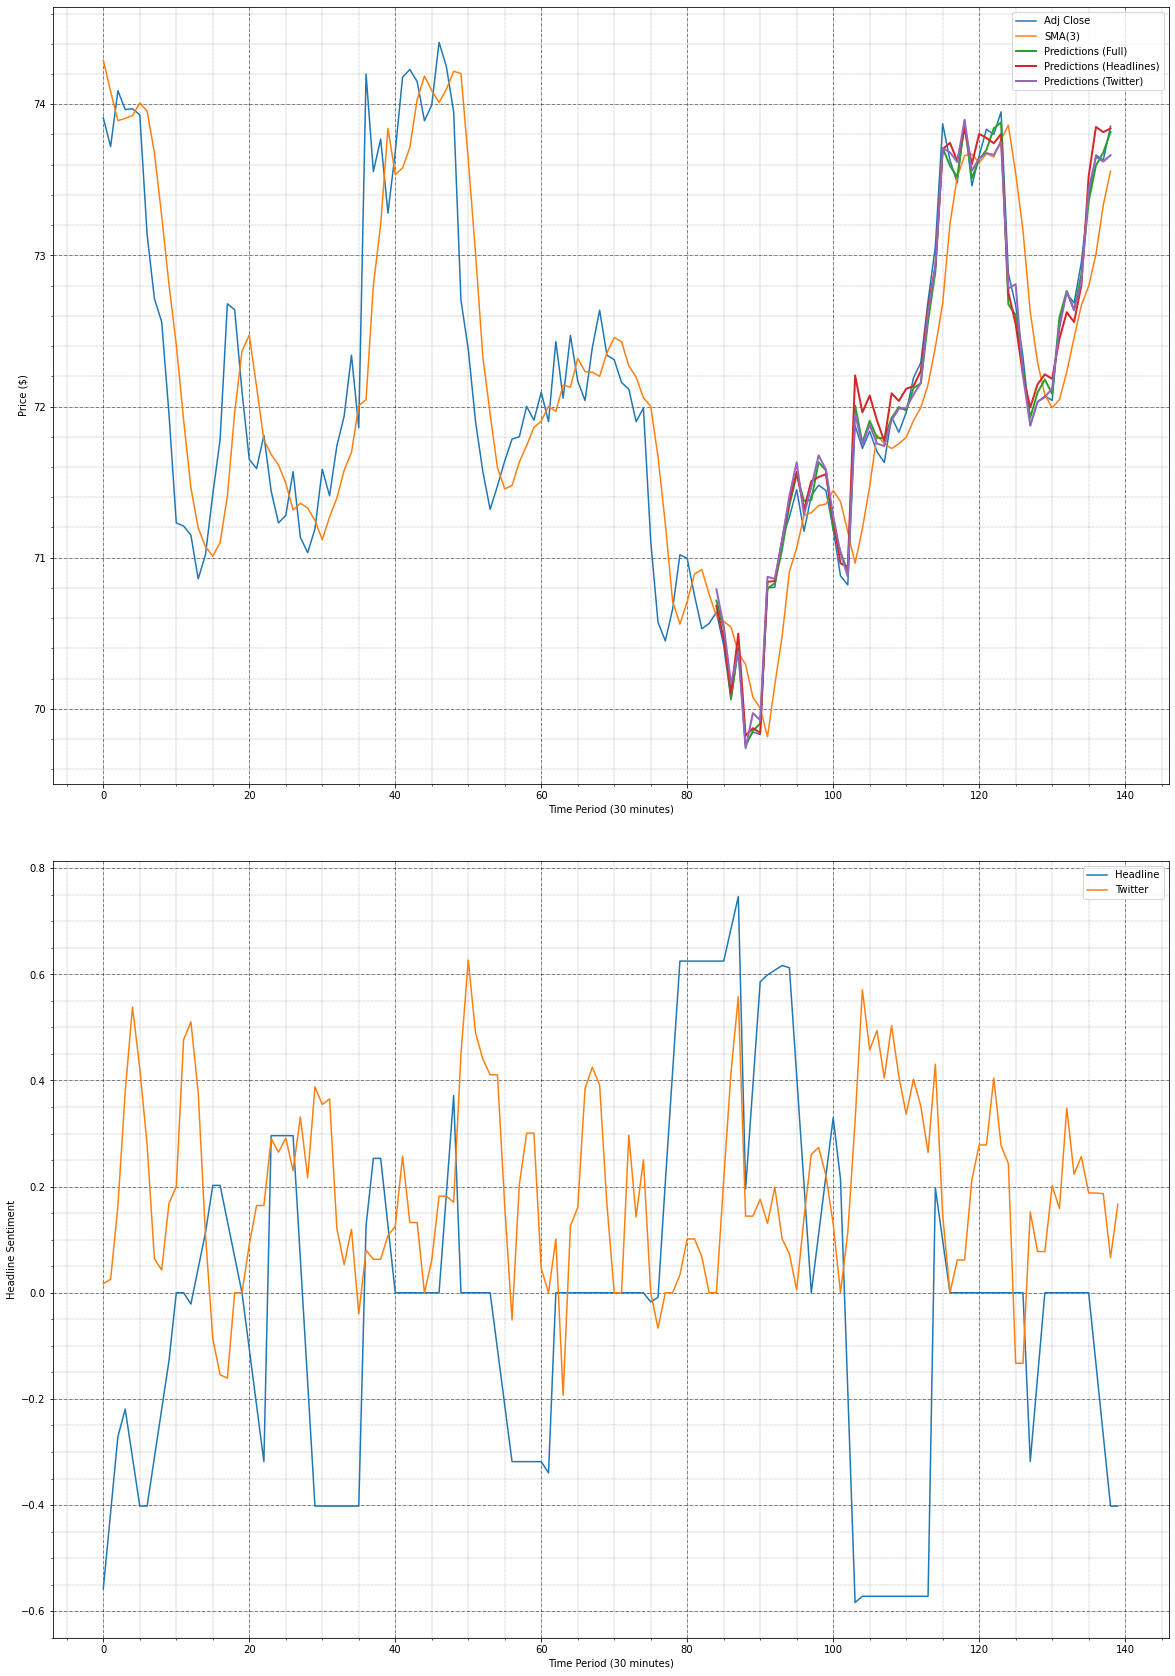

In [46]:
fig = plt.figure(figsize=(20,30))

price_ax = plt.subplot(2,1,1)
price_ax.plot(full_df.index[:-1], full_df['Adj Close'][:-1], label='Adj Close')
price_ax.plot(full_df.index[:-1], full_df['SMA(3)'][:-1], label='SMA(3)')
# price_ax.plot(full_df.index[i:-1], full_df['base price predictions linear'][i:-1], label='Predictions (base)',linewidth=2)
# price_ax.plot(full_df.index[:-1], full_df['full price predictions svr'][:-1], label='Full SVR training fit')
price_ax.plot(full_df.index[i:-1], full_df['full price predictions xgb'][i:-1], label='Predictions (Full)',linewidth=2)
# price_ax.plot(full_df.index[:-1], full_df['headlines price predictions svr'][:-1], label='Headlines SVR training fit')
price_ax.plot(full_df.index[i:-1], full_df['headlines price predictions svr'][i:-1], label='Predictions (Headlines)',linewidth=2)
# price_ax.plot(full_df.index[:-1], full_df['twitter price predictions svr'][:-1], label='Twitter SVR training fit')
price_ax.plot(full_df.index[i:-1], full_df['twitter price predictions svr'][i:-1], label='Predictions (Twitter)',linewidth=2)
price_ax.set_xlabel('Time Period (30 minutes)')
price_ax.set_ylabel('Price ($)')
price_ax.grid(which='major', color='k', linestyle='-.', linewidth=0.5)
price_ax.minorticks_on()
price_ax.grid(which='minor', color='k', linestyle=':', linewidth=0.3)
price_ax.legend()

roc_ax = plt.subplot(2,1,2, sharex=price_ax)
roc_ax.plot(full_df.index, full_df['Compound SMA(3) Headlines'],label='Headline')
roc_ax.plot(full_df.index, full_df['Compound SMA(3) Twitter'],label='Twitter')
roc_ax.set_xlabel('Time Period (30 minutes)')
roc_ax.set_ylabel('Headline Sentiment')
roc_ax.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
roc_ax.minorticks_on()
roc_ax.grid(which='minor', color='k', linestyle=':', linewidth=0.3)
roc_ax.legend()
plt.savefig('cvx.png')
fig.subplots_adjust(hspace=0.1)

## 3. Evaluate Model with Multiple Stocks:

In [73]:
def import_data2(ticker,ticker2,ticker3,ticker4,ticker5,ticker6,ticker7,ticker8,ticker9,ticker10,ticker11,ticker12,ticker13):
    stock_path = '~/LighthouseLabs-Final/Dataset/1. Stock_Data/'
    headline_path = '~/LighthouseLabs-Final/Dataset/2. FinViz_Headline_Data/'
    twitter_path = '~/LighthouseLabs-Final/Dataset/3. Twitter_Data/'
    latest_headlines='10-07'
    # 1. Historical Stock Data:------------------------------------------------------------------------------------------
    stock_df1 = pd.read_csv(stock_path+ticker+'_data.csv', index_col=0,parse_dates=['Datetime'])
    stock_df2 = pd.read_csv(stock_path+ticker2+'_data.csv',index_col=0, parse_dates=['Datetime'])
    stock_df3 = pd.read_csv(stock_path+ticker3+'_data.csv',index_col=0, parse_dates=['Datetime'])
    stock_df4 = pd.read_csv(stock_path+ticker4+'_data.csv',index_col=0, parse_dates=['Datetime'])
    stock_df5 = pd.read_csv(stock_path+ticker4+'_data.csv',index_col=0, parse_dates=['Datetime'])
    stock_df6 = pd.read_csv(stock_path+ticker4+'_data.csv',index_col=0, parse_dates=['Datetime'])
    stock_df7 = pd.read_csv(stock_path+ticker4+'_data.csv',index_col=0, parse_dates=['Datetime'])
    stock_df8 = pd.read_csv(stock_path+ticker4+'_data.csv',index_col=0, parse_dates=['Datetime'])
    stock_df9 = pd.read_csv(stock_path+ticker4+'_data.csv',index_col=0, parse_dates=['Datetime'])
    stock_df10 = pd.read_csv(stock_path+ticker4+'_data.csv',index_col=0, parse_dates=['Datetime'])
    stock_df11 = pd.read_csv(stock_path+ticker4+'_data.csv',index_col=0, parse_dates=['Datetime'])
    stock_df12 = pd.read_csv(stock_path+ticker4+'_data.csv',index_col=0, parse_dates=['Datetime'])
    stock_df13 = pd.read_csv(stock_path+ticker4+'_data.csv',index_col=0, parse_dates=['Datetime'])

    # 2. Headline Data: ----------------------------------------------------------------------------------------------------
    headlines1 = pd.read_csv(headline_path+ticker+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines2 = pd.read_csv(headline_path+ticker2+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines3 = pd.read_csv(headline_path+ticker3+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines4 = pd.read_csv(headline_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines5 = pd.read_csv(headline_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines6 = pd.read_csv(headline_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines7 = pd.read_csv(headline_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines8 = pd.read_csv(headline_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines9 = pd.read_csv(headline_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines10 = pd.read_csv(headline_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines11 = pd.read_csv(headline_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines12 = pd.read_csv(headline_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])
    headlines13 = pd.read_csv(headline_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0, parse_dates=['date_time'])

    # 3. Twitter Data:----------------------------------------------------------------------------------------------------
    twitter1 = pd.read_csv(twitter_path+ticker+'_2020-09-23_2020-'+latest_headlines+'.csv', index_col=0,parse_dates=['timestamp'])
    twitter2 = pd.read_csv(twitter_path+ticker2+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])
    twitter3 = pd.read_csv(twitter_path+ticker3+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])
    twitter4 = pd.read_csv(twitter_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])
    twitter5 = pd.read_csv(twitter_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])
    twitter6 = pd.read_csv(twitter_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])
    twitter7 = pd.read_csv(twitter_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])
    twitter8 = pd.read_csv(twitter_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])
    twitter9 = pd.read_csv(twitter_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])
    twitter10 = pd.read_csv(twitter_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])
    twitter11 = pd.read_csv(twitter_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])
    twitter12 = pd.read_csv(twitter_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])
    twitter13 = pd.read_csv(twitter_path+ticker4+'_2020-09-23_2020-'+latest_headlines+'.csv',index_col=0, parse_dates=['timestamp'])


    return stock_df1,headlines1,twitter1, stock_df2,headlines2,twitter2, stock_df3,headlines3,twitter3, stock_df4,headlines4,twitter4, stock_df5,headlines5,twitter5, stock_df6,headlines6,twitter6 , stock_df7,headlines7,twitter7, stock_df8,headlines8,twitter8, stock_df9,headlines9,twitter9, stock_df10,headlines10,twitter10, stock_df11,headlines11,twitter11, stock_df12,headlines12,twitter12, stock_df13,headlines13,twitter13

In [74]:
def cleaning_df(stock_df, headline_df, twitter_df):
    #2. Headline Final Merge:
    headlines_final = preprocess_headlines(headline_df)
    with_headlines_df = stock_df.merge(headlines_final, left_on='Datetime', right_on='timestamp').drop('timestamp',axis=1)
    with_headlines_df['t+1'] = with_headlines_df['Adj Close'].shift(-1)
    #3. Twitter Final Merge:
    final_twitter = preprocess_posts(twitter_df)
    with_twitter_df = stock_df.merge(final_twitter, left_on='Datetime', right_on='timestamp').drop('timestamp',axis=1)
    with_twitter_df['t+1'] = with_twitter_df['Adj Close'].shift(-1)
    #4. Full Merge:
    full_df = with_twitter_df.merge(headlines_final, left_on='Datetime', right_on='timestamp').drop('timestamp',axis=1)
    full_df['t+1'] = full_df['Adj Close'].shift(-1)

    return with_headlines_df,with_twitter_df,full_df

In [75]:
stock_df1,headlines1,twitter1, stock_df2,headlines2,twitter2, stock_df3,headlines3,twitter3, stock_df4,headlines4,twitter4, stock_df5,headlines5,twitter5, stock_df6,headlines6,twitter6 , stock_df7,headlines7,twitter7, stock_df8,headlines8,twitter8, stock_df9,headlines9,twitter9, stock_df10,headlines10,twitter10, stock_df11,headlines11,twitter11, stock_df12,headlines12,twitter12, stock_df13,headlines13,twitter13 = import_data2('TSLA','AMZN','AAPL','GOOG', 'FB', 'NFLX', 'CVX','GS','JNJ','NVDA','PFE','NKE','MSFT')

In [76]:
stock_df1['Percent Price Change Within Period (t+1)'] = stock_df1['Percent Price Change Within Period'].shift(-1)
stock_df2['Percent Price Change Within Period (t+1)'] = stock_df2['Percent Price Change Within Period'].shift(-1)
stock_df3['Percent Price Change Within Period (t+1)'] = stock_df3['Percent Price Change Within Period'].shift(-1)
stock_df4['Percent Price Change Within Period (t+1)'] = stock_df4['Percent Price Change Within Period'].shift(-1)

stock_df5['Percent Price Change Within Period (t+1)'] = stock_df5['Percent Price Change Within Period'].shift(-1)
stock_df6['Percent Price Change Within Period (t+1)'] = stock_df6['Percent Price Change Within Period'].shift(-1)
stock_df7['Percent Price Change Within Period (t+1)'] = stock_df7['Percent Price Change Within Period'].shift(-1)
stock_df8['Percent Price Change Within Period (t+1)'] = stock_df8['Percent Price Change Within Period'].shift(-1)

stock_df9['Percent Price Change Within Period (t+1)'] = stock_df9['Percent Price Change Within Period'].shift(-1)
stock_df10['Percent Price Change Within Period (t+1)'] = stock_df10['Percent Price Change Within Period'].shift(-1)
stock_df11['Percent Price Change Within Period (t+1)'] = stock_df11['Percent Price Change Within Period'].shift(-1)
stock_df12['Percent Price Change Within Period (t+1)'] = stock_df12['Percent Price Change Within Period'].shift(-1)

stock_df13['Percent Price Change Within Period (t+1)'] = stock_df13['Percent Price Change Within Period'].shift(-1)

In [77]:
tsla_headlines_df, tsla_twitter_df, tsla_full_df = cleaning_df(stock_df1, headlines1, twitter1)
amzn_headlines_df, amzn_twitter_df, amzn_full_df = cleaning_df(stock_df2, headlines2, twitter2)
aapl_headlines_df, aapl_twitter_df, aapl_full_df = cleaning_df(stock_df3, headlines3, twitter3)
goog_headlines_df, goog_twitter_df, goog_full_df = cleaning_df(stock_df4, headlines4, twitter4)

fb_headlines_df, fb_twitter_df, fb_full_df = cleaning_df(stock_df5, headlines5, twitter5)
nflx_headlines_df, nflx_twitter_df, nflx_full_df = cleaning_df(stock_df6, headlines6, twitter6)
cvx_headlines_df, cvx_twitter_df, cvx_full_df = cleaning_df(stock_df7, headlines7, twitter7)
gs_headlines_df, gs_twitter_df, gs_full_df = cleaning_df(stock_df8, headlines8, twitter8)

jnj_headlines_df, jnj_twitter_df, jnj_full_df = cleaning_df(stock_df9, headlines9, twitter9)
nvda_headlines_df, nvda_twitter_df, nvda_full_df = cleaning_df(stock_df10, headlines10, twitter10)
pfe_headlines_df, pfe_twitter_df, pfe_full_df = cleaning_df(stock_df11, headlines11, twitter11)
nke_headlines_df, nke_twitter_df, nke_full_df = cleaning_df(stock_df12, headlines12, twitter12)

msft_headlines_df, msft_twitter_df, msft_full_df = cleaning_df(stock_df13, headlines13, twitter13)

In [78]:
stock_frames = [stock_df1, stock_df2, stock_df3, stock_df4, stock_df5, stock_df6, stock_df7, stock_df8, stock_df9, stock_df10, stock_df11, stock_df12, stock_df13]
full_stocks = pd.concat(stock_frames)

headline_frames = [tsla_headlines_df, amzn_headlines_df, aapl_headlines_df, goog_headlines_df,fb_headlines_df,nflx_headlines_df,cvx_headlines_df,gs_headlines_df,jnj_headlines_df,nvda_headlines_df,pfe_headlines_df,nke_headlines_df,msft_headlines_df]
full_headlines = pd.concat(headline_frames)

twitter_frames = [tsla_twitter_df,amzn_twitter_df,aapl_twitter_df,goog_twitter_df,fb_twitter_df,nflx_twitter_df,cvx_twitter_df,gs_twitter_df,jnj_twitter_df,nvda_twitter_df,pfe_twitter_df,nke_twitter_df,msft_twitter_df]
full_twitter = pd.concat(twitter_frames)

full_frames = [tsla_full_df,amzn_full_df,aapl_full_df,goog_full_df,fb_full_df,nflx_full_df,cvx_full_df,gs_full_df,jnj_full_df,nvda_full_df,pfe_full_df,nke_full_df,msft_full_df]
full_final = pd.concat(full_frames)

In [62]:
full_final.shape

(1803, 17)

In [79]:
full_stocks.dropna(inplace=True)
lm_baseline_rmse,lm_baseline_r2,sgd_baseline_rmse,sgd_baseline_r2 = linear_modeling_no_sentiment(full_stocks)

full_headlines.dropna(inplace=True)
lm_headlines_rmse,lm_headlines_r2,sgd_headlines_rmse,sgd_headlines_r2,xgb_headlines_rmse,xgb_headlines_r2,svr_headlines_rmse,svr_headlines_r2  = linear_modeling_headlines(full_headlines)

full_twitter.dropna(inplace=True)
lm_twitter_rmse,lm_twitter_r2,sgd_twitter_rmse,sgd_twitter_r2,xgb_twitter_rmse,xgb_twitter_r2,svr_twitter_rmse,svr_twitter_r2=linear_model_twitter(full_twitter)

full_final.dropna(inplace=True)
lm_all_rmse,lm_all_r2,sgd_all_rmse,sgd_all_r2,xgb_all_rmse,xgb_all_r2,rf_all_rmse,rf_all_r2,svr_all_rmse,svr_all_r2=multi_model_full(full_final)

In [80]:
result_dict = {
    'Linear RMSE - Baseline':lm_baseline_rmse, 'Linear R2 - Baseline':lm_baseline_r2, 'SGD RMSE - Baseline':sgd_baseline_rmse, 'SGD R2 - Baseline':sgd_baseline_r2,
    'Linear RMSE - Only Headlines': lm_headlines_rmse, 'Linear R2 - Only Headlines':lm_headlines_r2, 'SGD RMSE - Only Headlines':sgd_headlines_rmse, 'SGD R2 - Only Headlines':sgd_headlines_r2, 'XGB RMSE - Only Headlines':xgb_headlines_rmse, 'XGB R2 - Only Headlines':xgb_headlines_r2, 'SVR RMSE - Only Headlines':svr_headlines_rmse, 'SVR R2 - Only Headlines': svr_headlines_r2,
    'Linear RMSE - Only Twitter':lm_twitter_rmse, 'Linear R2 - Only Twitter':lm_twitter_r2, 'SGD RMSE - Only Twitter':sgd_twitter_rmse, 'SGD R2 - Only Twitter':sgd_twitter_r2, 'XGB RMSE - Only Twitter':xgb_twitter_rmse, 'XGB R2 - Only Twitter':xgb_twitter_r2,'SVR RMSE - Only Twitter':svr_twitter_rmse,'SVR R2 - Only Twitter':svr_twitter_r2,
    'Linear RMSE - All':lm_all_rmse, 'Linear R2 - All':lm_all_r2, 'SGD RMSE - All':sgd_all_rmse, 'SGD R2 - All':sgd_all_r2, 'XGB RMSE - All':xgb_all_rmse, 'XGB R2 - All':xgb_all_r2, 'RF RMSE - All':rf_all_rmse,'RF R2 - All':rf_all_r2,'SVR RMSE - All':svr_all_rmse,'SVR R2 - All':svr_all_r2
    }
    #7. Convert to DataFrame:
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Values'])
# result_df.to_csv('~/LighthouseLabs-Final/Report_Analysis/grouped_stocks_complete_analysis2.csv')

In [81]:
result_dict = {
    'Linear RMSE - Baseline':lm_baseline_rmse, 'SGD RMSE - Baseline':sgd_baseline_rmse,
    'Linear RMSE - Only Headlines': lm_headlines_rmse, 'SGD RMSE - Only Headlines':sgd_headlines_rmse, 'XGB RMSE - Only Headlines':xgb_headlines_rmse, 'SVR RMSE - Only Headlines':svr_headlines_rmse,
    'Linear RMSE - Only Twitter':lm_twitter_rmse, 'SGD RMSE - Only Twitter':sgd_twitter_rmse, 'XGB RMSE - Only Twitter':xgb_twitter_rmse, 'SVR RMSE - Only Twitter':svr_twitter_rmse,
    'Linear RMSE - All':lm_all_rmse, 'SGD RMSE - All':sgd_all_rmse, 'XGB RMSE - All':xgb_all_rmse, 'RF RMSE - All':rf_all_rmse,'SVR RMSE - All':svr_all_rmse
    }
result_df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Values'])

In [82]:
result_df

,Values
Linear RMSE - Baseline,1.963079e-01
SGD RMSE - Baseline,2.920117e+14
Linear RMSE - Only Headlines,2.292830e-01
SGD RMSE - Only Headlines,3.509557e+15
XGB RMSE - Only Headlines,8.809328e-05
SVR RMSE - Only Headlines,2.015862e-01
Linear RMSE - Only Twitter,2.438640e-01
SGD RMSE - Only Twitter,7.305467e+14
XGB RMSE - Only Twitter,1.109389e-04
SVR RMSE - Only Twitter,2.015820e-01


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

i = len(full_df['Percent Price Change Within Period (t+1)'])-4
y_train, y_test = full_df['Percent Price Change Within Period (t+1)'][:i], full_df['Percent Price Change Within Period (t+1)'][i:-1]
X_train, X_test = full_df[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][:i], full_df[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][i:-1]

svr = SVR()
scorer = make_scorer(mean_squared_error, greater_is_better=False)
parameters = {'kernel': ['rbf', 'linear'],
              'C': [0.01,0.1, 0.2, 0.5, 1, 5, 10], #so called `eta` value
              'epsilon': [0.00001,0.0001,0.001]}

svr_grid = GridSearchCV(svr,
                        parameters,
                        scoring=scorer,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

svr_grid.fit(X_train,
         y_train)

print(svr_grid.best_score_)
print(svr_grid.best_params_)

Fitting 2 folds for each of 42 candidates, totalling 84 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
-0.27361851573947704
{'C': 0.1, 'epsilon': 0.001, 'kernel': 'linear'}
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done  84 out of  84 | elapsed:    1.8s finished


In [150]:
from sklearn.model_selection import GridSearchCV
rf_regr=RandomForestRegressor(criterion='mse')
estimators = [18,20,22]
max_depths = [200, 400, 500, 600, 700]
params = [{'n_estimators': estimators, 'max_depth':max_depths}]
clf = GridSearchCV(estimator=rf_regr, param_grid=params, n_jobs =-1)

i = len(full_final['t+1'])-4
y_train, y_test = full_final['t+1'][:i], full_final['t+1'][i:-1]
X_train, X_test = full_final[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][:i], full_final[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][i:-1]

best_model = clf.fit(X_train,y_train)
clf.best_params_

{&#39;max_depth&#39;: 600, &#39;n_estimators&#39;: 20}

In [18]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# full_final.dropna(inplace=True)

i = len(full_df['Percent Price Change Within Period (t+1)'])-4
y_train, y_test = full_df['Percent Price Change Within Period (t+1)'][:i], full_df['Percent Price Change Within Period (t+1)'][i:-1]
X_train, X_test = full_df[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][:i], full_df[['Adj Close','Scaled Volume','compound_y','compound_x','Compound SMA(3) Headlines','Compound SMA(3) Twitter','SMA(3)','change in sentiment headlines','change in sentiment headlines (t-1)','change in sentiment twitter','change in sentiment twitter (t-1)']][i:-1]

xgb1 = xgb.XGBRegressor()
scorer = make_scorer(mean_squared_error, greater_is_better=False)
parameters = {"learning_rate":[0.05, 0.10, 0.20],
              "max_depth": [ 3, 4, 5],
              "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
              "colsample_bytree" : [ 0.3, 0.4, 0.5 ],
              'n_estimators': [5, 10, 1000, 10000, 20000]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        scoring=scorer,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 675 candidates, totalling 1350 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  98 tasks      | elapsed:    8.7s
[Parallel(n_jobs=5)]: Done 260 tasks      | elapsed:   36.9s
[Parallel(n_jobs=5)]: Done 510 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 860 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done 1310 tasks      | elapsed:  3.9min
-0.29604396601121596
{'colsample_bytree': 0.3, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 10}
[Parallel(n_jobs=5)]: Done 1350 out of 1350 | elapsed:  4.1min finished
